In [1]:
import os, sys
import tqdm
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import pickle
import torch
from src.visualization import plot_action
from src.preprocess_data import preprocess_data

In [3]:
test_dataset = pd.read_csv('../result/test_dataset.csv')
test_dataset['freeze_frame'] = test_dataset['freeze_frame'].apply(ast.literal_eval)
print(test_dataset.shape)
test_dataset.head()

(310, 25)


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,...,goal,ownGoal,teamId,eventName,subEventName,accurate,freeze_frame,value_label,game_id,pass_id
0,Home,PASS,PASS,2,35157,3515.7,35166,3516.6,B26,B27,...,0,0,1,Pass,Pass,1,"{'A01': {'teammate': False, 'actor': False, 'b...",0,3,5959
1,Away,PASS,PASS,2,32850,3285.0,32861,3286.1,A10,A06,...,0,0,2,Pass,Pass,1,"{'A01': {'teammate': True, 'actor': False, 'ba...",0,3,5759
2,Away,PASS,PASS,2,38326,3832.6,38336,3833.6,A04,A08,...,0,0,2,Pass,Pass,1,"{'A01': {'teammate': True, 'actor': False, 'ba...",0,3,6091
3,Home,PASS,PASS,2,56928,5692.8,56944,5694.4,B35,B30,...,0,0,1,Pass,Pass,1,"{'A01': {'teammate': False, 'actor': False, 'b...",0,3,7265
4,Home,PASS,PASS,2,35254,3525.4,35271,3527.1,B18,B23,...,0,0,1,Pass,Pass,1,"{'A01': {'teammate': False, 'actor': False, 'b...",0,3,5968


In [4]:
import ast 
all_events = pd.read_csv('../metrica-data/EPV-data/all-match.csv')
all_events['freeze_frame'] = all_events['freeze_frame'].apply(ast.literal_eval)
all_events.head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,...,goal,ownGoal,teamId,eventName,subEventName,accurate,freeze_frame,value_label,game_id,pass_id
0,Away,SET PIECE,KICK OFF,1,1,0.1,0,0.0,B19,NaN,...,0,0,2,Set piece,Kick off,0,{},0,1,0
1,Away,PASS,PASS,1,1,0.1,2,0.2,B19,B21,...,0,0,2,Pass,Pass,1,"{'B25': {'teammate': True, 'actor': False, 'ba...",0,1,1
2,Away,PASS,PASS,1,2,0.2,7,0.7,B21,B15,...,0,0,2,Pass,Pass,1,"{'B25': {'teammate': True, 'actor': False, 'ba...",0,1,2
3,Away,PASS,PASS,1,18,1.8,25,2.5,B15,B19,...,0,0,2,Pass,Pass,1,"{'B25': {'teammate': True, 'actor': False, 'ba...",0,1,3
4,Away,PASS,PASS,1,31,3.1,39,3.9,B19,B21,...,0,0,2,Pass,Pass,1,"{'B25': {'teammate': True, 'actor': False, 'ba...",0,1,4


In [5]:
all_events[all_events['eventName'] == 'Pass']['accurate'].value_counts()

accurate
1    2884
0     420
Name: count, dtype: int64

In [6]:
all_events[all_events['eventName'] == 'Pass']['value_label'].value_counts()

value_label
 0    3257
 1      42
-1       5
Name: count, dtype: int64

In [19]:
# import numpy as np
# actions = ['Pass','Carry','Shot']

# actions_dict = {}
# total_events = len(all_events[all_events['eventName'].isin(actions)])

# for index, col in enumerate(actions):
#     action_count = len(all_events[all_events['eventName']==col])
#     actions_dict[index] = action_count / total_events

# print(actions_dict)
# np.random.multinomial(1, [actions_dict[0], actions_dict[1], actions_dict[2]], size=1)

In [6]:
def load_surface(path):
    path = '../result/' + path + '.pkl'
    with open(path, 'rb') as f:
        surface = pickle.load(f)
    return surface

In [7]:
surface_success = load_surface(path='pass_success_probability_surface')
surface_selection = load_surface(path='pass_selection_probability_surface')
surface_value = load_surface(path='pass_value_probability_surface')
len(surface_success.keys()), len(surface_selection.keys()), len(surface_value.keys())

(310, 310, 310)

### 성능

In [22]:
test_dataset['accurate'].value_counts()

accurate
1    274
0     36
Name: count, dtype: int64

In [23]:
test_dataset['value_label'].value_counts()

value_label
0    307
1      3
Name: count, dtype: int64

In [27]:
from glob import glob

def pass_surface_save(path, surface):
    with open(path, 'wb') as f:
        pickle.dump(surface, f)
        
def find_checkpoint(component):
    # 체크포인트 디렉토리 설정
    base_path = f'../runs/{component}'

    # 해당 경로에 있는 모든 'version' 폴더를 찾음
    version_dirs = glob(os.path.join(base_path, 'version*'))

    # 가장 최근 버전 폴더 찾기 (가장 높은 숫자를 가진 폴더)
    latest_version_dir = max(version_dirs, key=lambda x: int(x[-1]))

    # 해당 버전 폴더 내의 모든 '.ckpt' 파일을 찾음
    ckpt_files = glob(os.path.join(latest_version_dir, '*.ckpt'))

    return ckpt_files[0]

In [25]:
from unxpass.components import pass_success, pass_selection, pass_value
from unxpass.datasets import PassesDataset

field_dim = (72, 108)

success_test_dataset = PassesDataset(test_dataset, transform = pass_success.ToSoccerMapTensor(dim=field_dim))
selection_test_dataset = PassesDataset(test_dataset, transform = pass_selection.ToSoccerMapTensor(dim=field_dim))
value_test_dataset = PassesDataset(test_dataset, transform = pass_value.ToSoccerMapTensor(dim=field_dim))

In [26]:
pass_success_ckpt = find_checkpoint("pass_success")
pass_selection_ckpt = find_checkpoint("pass_selection")
pass_value_ckpt = find_checkpoint("pass_value")

pass_success_ckpt, pass_selection_ckpt, pass_value_ckpt

('../runs/pass_success/version_0/val_loss=0.36.ckpt',
 '../runs/pass_selection/version_0/val_loss=6.02.ckpt',
 '../runs/pass_value/version_0/val_loss=0.01.ckpt')

In [34]:
import torch

pass_success_model = pass_success.PytorchSoccerMapModel()
checkpoint = torch.load(pass_success_ckpt, map_location='cpu')
pass_success_model.load_state_dict(checkpoint['state_dict'])
model_pass_success = pass_success.PassSuccessComponent(model=pass_success_model)
metric_pass_success = model_pass_success.test(success_test_dataset)
print("pass success metric: ",metric_pass_success)
surface_pass_success = model_pass_success.predict_surface(success_test_dataset)
pass_surface_save('../result/pass_success_probability_surface.pkl', surface_pass_success)

Missing logger folder: ./runs/pass_success
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Output()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


pass success metric:  {'precision': 0.8838709677419355, 'recall': 1.0, 'f1': 0.9383561643835616, 'log_loss': 0.3307171568035226, 'brier': 0.09427737278993413, 'roc_auc': 0.7130981346309814, 'soccermap_ece': array([0.04762203]), 'epv_ece': array([0.04762203]), 'bce_l1': tensor(0.0476)}


Predicting: |          | 0/? [00:00<?, ?it/s]

In [36]:
pass_selection_model = pass_selection.PytorchSoccerMapModel()
checkpoint = torch.load(pass_selection_ckpt, map_location='cpu')
pass_selection_model.load_state_dict(checkpoint['state_dict'])
model_pass_selection = pass_selection.PassSelectionComponent(model=pass_selection_model)
metric_pass_selection = model_pass_selection.test(selection_test_dataset)
print("pass selection metric: ",metric_pass_selection)
surface_pass_selection= model_pass_selection.predict_surface(selection_test_dataset)
pass_surface_save('../result/pass_selection_probability_surface.pkl', surface_pass_selection)

Missing logger folder: ./runs/pass_selection
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Output()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


pass selection metric:  {'log_loss': 5.9698490856809565, 'Accuracy': 0.43870967741935485}


Predicting: |          | 0/? [00:00<?, ?it/s]

In [37]:
#주의!주의!주의!주의!주의!주의!주의!주의!주의!주의!주의!
#channel.py -> find_checkpoint() -> base_path = '../runs/pass_success'로 변경(.하나 추가함)
#경로가 상대 경로이다보니까 train.py에서 실행할 때랑 다르므로 주의!

pass_value_model = pass_value.PytorchSoccerMapModel()
checkpoint = torch.load(pass_value_ckpt, map_location='cpu')
pass_value_model.load_state_dict(checkpoint['state_dict'])
model_pass_value = pass_value.PassValueComponent(model=pass_value_model)
metric_pass_value = model_pass_value.test(value_test_dataset)
print("pass value metric: ",metric_pass_value)
surface_pass_value = model_pass_value.predict_surface(value_test_dataset)
pass_surface_save('../result/pass_value_probability_surface.pkl', surface_pass_value)

Missing logger folder: ./runs/pass_value
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Output()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


pass value metric:  {'MSE': 0.011829055}


Predicting: |          | 0/? [00:00<?, ?it/s]

### 확률표면

In [13]:
test_dataset[test_dataset['value_label'] == 1]

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,to,...,goal,ownGoal,teamId,eventName,subEventName,accurate,freeze_frame,value_label,game_id,pass_id
51,Home,BALL LOST,INTERCEPTION,2,32230,3223.0,32254,3225.4,B24,NaN,...,0,0,1,Pass,Interception,0,"{'A01': {'teammate': False, 'actor': False, 'b...",1,3,5745
55,Home,PASS,PASS,2,32157,3215.7,32176,3217.6,B24,B21,...,0,0,1,Pass,Pass,1,"{'A01': {'teammate': False, 'actor': False, 'b...",1,3,5741
234,Home,PASS,PASS,2,32202,3220.2,32210,3221.0,B21,B24,...,0,0,1,Pass,Pass,1,"{'A01': {'teammate': False, 'actor': False, 'b...",1,3,5743


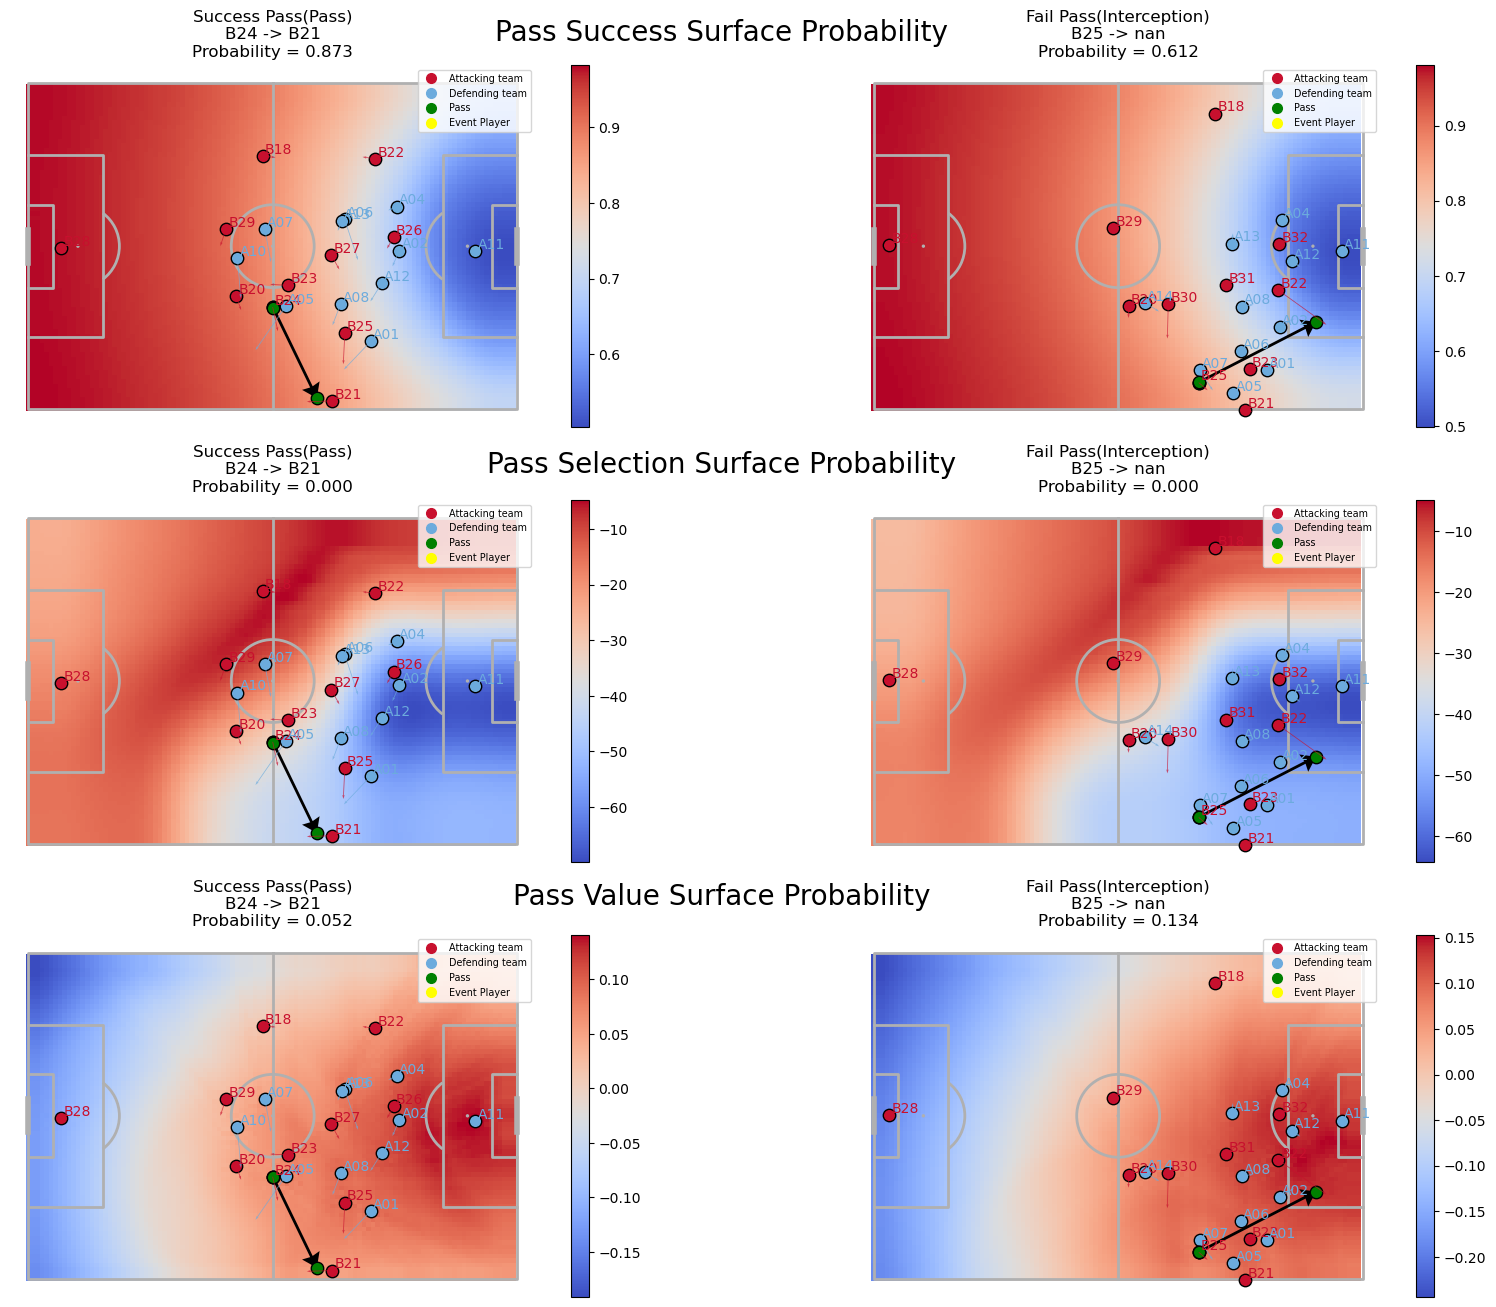

In [17]:
pass_ids = [5741, 6168]

fig, ax = plt.subplots(3,2,figsize=(20,16))

ax_id = [ax[0,0], ax[0,1]]
for index, pass_id in enumerate(pass_ids):
    record = test_dataset[test_dataset['pass_id'] == pass_id].squeeze()
    plot_action(record, surface=surface_success[pass_id],ax=ax_id[index],field_dimen=(108,72))

ax_id = [ax[1,0], ax[1,1]]
for index, pass_id in enumerate(pass_ids):
    record = test_dataset[test_dataset['pass_id'] == pass_id].squeeze()
    plot_action(record, surface=surface_selection[pass_id], ax=ax_id[index], log_bool=True, field_dimen=(108,72))

ax_id = [ax[2,0], ax[2,1]]
for index, pass_id in enumerate(pass_ids):
    record = test_dataset[test_dataset['pass_id'] == pass_id].squeeze()
    plot_action(record, surface=surface_value[pass_id], ax=ax_id[index], field_dimen=(108,72))


fig.text(0.5, 0.9, "Pass Success Surface Probability", ha='center', va='center', fontsize=20)
fig.text(0.5, 0.63, "Pass Selection Surface Probability", ha='center', va='center', fontsize=20)
fig.text(0.5, 0.36, "Pass Value Surface Probability", ha='center', va='center', fontsize=20)

plt.show()